<a href="https://colab.research.google.com/github/vsnupoudel/DeepLearning-Exercises/blob/main/Testing_and_Training_of_Hair_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hair segmentation using DeepLearning

In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Download images and choose appropriate images

In [10]:
import pathlib
dataset_url = "http://projects.i-ctm.eu/sites/default/files/AltroMateriale/207_Michele%20Svanera/Figaro1k.zip"
data_dir = tf.keras.utils.get_file(origin=dataset_url
                                   ,extract=True
                                   , fname = 'Figaro1k_Photos')
file_dir = pathlib.Path(data_dir)

66543616/66542098 [==============================] - 4s 0us/step


In [4]:
# !ls -all  /root/.keras/datasets/Figaro1k/GT/Training

Prepare a sorted list of images.

In [23]:
import os
base_dir = '/root/.keras/datasets/Figaro1k/'

# Directory with the training pictures
training_dir = os.path.join(base_dir, 'Original/Training')
testing_dir = os.path.join(base_dir, 'Original/Testing')

# Directory with our target pictures pictures
training_mask_dir = os.path.join(base_dir, 'GT/Training')
testing_mask_dir = os.path.join(base_dir, 'GT/Testing')

input_img_paths = sorted(
    [
        os.path.join(training_dir, fname)
        for fname in os.listdir(training_dir)
        if fname.endswith(".jpg")
    ] )
target_img_paths = sorted(
    [
        os.path.join(training_mask_dir, fname)
        for fname in os.listdir(training_mask_dir)
        if fname.endswith("gt.pbm") 
    ] )

test_img_paths = sorted([
        os.path.join(testing_dir, fname)
        for fname in os.listdir(testing_dir)
        if fname.endswith(".jpg")
    ] )

test_mask_paths = sorted([
        os.path.join(testing_mask_dir, fname)
        for fname in os.listdir(testing_mask_dir)
        if fname.endswith("gt.pbm")
    ] )

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:5], target_img_paths[:5]):
    print(input_path, "|", target_path)

Number of samples: 840
/root/.keras/datasets/Figaro1k/Original/Training/Frame00001-org.jpg | /root/.keras/datasets/Figaro1k/GT/Training/Frame00001-gt.pbm
/root/.keras/datasets/Figaro1k/Original/Training/Frame00002-org.jpg | /root/.keras/datasets/Figaro1k/GT/Training/Frame00002-gt.pbm
/root/.keras/datasets/Figaro1k/Original/Training/Frame00003-org.jpg | /root/.keras/datasets/Figaro1k/GT/Training/Frame00003-gt.pbm
/root/.keras/datasets/Figaro1k/Original/Training/Frame00004-org.jpg | /root/.keras/datasets/Figaro1k/GT/Training/Frame00004-gt.pbm
/root/.keras/datasets/Figaro1k/Original/Training/Frame00005-org.jpg | /root/.keras/datasets/Figaro1k/GT/Training/Frame00005-gt.pbm


Plot the images and their masks, 9 at a time...

In [24]:
pic_index = 0

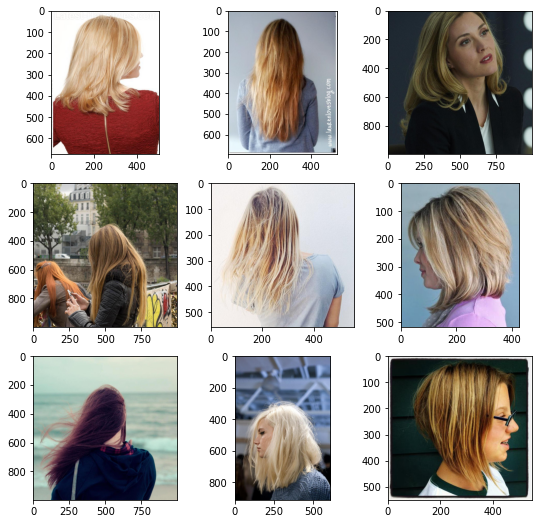

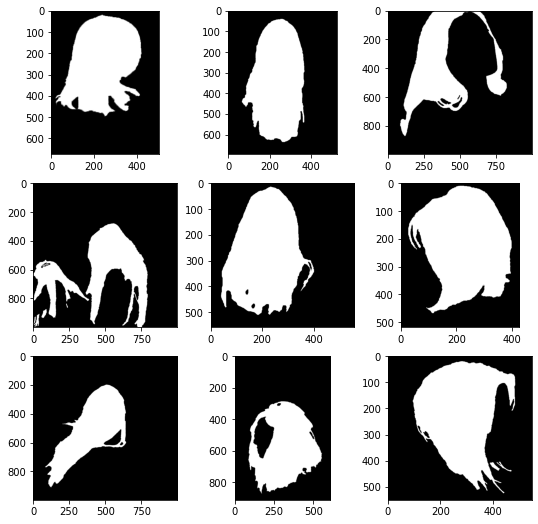

In [30]:
import matplotlib.image as mpimg

pic_index+=9
# Display input image #7
fig, ax = plt.subplots(3,3 , figsize=(9,9))
fig1, ax1 = plt.subplots(3,3 , figsize=(9,9))
for i in range(3):
  for j in range(3):    
    img = mpimg.imread( input_img_paths[pic_index]  )
    ax[i,j].imshow( img )
    img = mpimg.imread( target_img_paths[pic_index]  )
    ax1[i,j].imshow( img )
    pic_index+= 1
# display(Image(filename=input_img_paths[9]))
plt.show()

Putting the images in a batch like format.
Reference. [link text](https://keras.io/examples/vision/oxford_pets_image_segmentation/)

In [31]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

img_size = (256, 256)
num_classes = 2
batch_size = 32

class HairSegSeq(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")

        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            #  tf.cast(input_image, tf.float32) / 255.0
            arr = tf.cast( img_to_array(img)/255.0 , tf.float32) 
            # img = array_to_img( arr, scale = False )
            x[j] = arr
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            y[j] = np.where( y[j] ==255,1 , 0 )
            # y[j] -= 1
        return x, y

Test the batch-like format.

In [32]:
train_gen = HairSegSeq(
    batch_size, img_size, test_img_paths, test_mask_paths
)

In [33]:
train_gen.__getitem__(0)[0].shape

(32, 256, 256, 3)

Prepare U-Net Xception-style model

In [34]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, 3 , activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
# model.summary()

Set aside validation samples.

In [35]:
train_gen = HairSegSeq(
    batch_size, img_size, input_img_paths, target_img_paths
)
val_gen = HairSegSeq(batch_size, img_size, test_img_paths , test_mask_paths )

Train the model.

In [36]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0005, beta_1 = 0.9)
              , loss="binary_crossentropy", metrics = ['accuracy'])

checkpoint_filepath = '/content'
callbacks = [
    keras.callbacks.ModelCheckpoint(  filepath= checkpoint_filepath+"/hair_segmentation.h5"
                                    ,save_best_only=True)
]

In [37]:
# Train the model, doing validation at the end of each epoch.
epochs = 50
model.fit(train_gen, epochs=epochs, validation_data=val_gen
          , callbacks=callbacks)

Epoch 1/50
26/26 [==============================] - 53s 585ms/step - loss: 1.1017 - accuracy: 0.7474 - val_loss: 1.2549 - val_accuracy: 0.6510
Epoch 2/50
26/26 [==============================] - 15s 553ms/step - loss: 0.3166 - accuracy: 0.8712 - val_loss: 0.7628 - val_accuracy: 0.6415
Epoch 3/50
26/26 [==============================] - 15s 557ms/step - loss: 0.2556 - accuracy: 0.8937 - val_loss: 0.6967 - val_accuracy: 0.6274
Epoch 4/50
26/26 [==============================] - 15s 563ms/step - loss: 0.2326 - accuracy: 0.9042 - val_loss: 0.6275 - val_accuracy: 0.6271
Epoch 5/50
26/26 [==============================] - 15s 564ms/step - loss: 0.2270 - accuracy: 0.9040 - val_loss: 0.5856 - val_accuracy: 0.6212
Epoch 6/50
26/26 [==============================] - 15s 571ms/step - loss: 0.2304 - accuracy: 0.9031 - val_loss: 0.6476 - val_accuracy: 0.6387
Epoch 7/50
26/26 [==============================] - 15s 580ms/step - loss: 0.1854 - accuracy: 0.9229 - val_loss: 0.5999 - val_accuracy: 0.7334

Test to predict a fresh image, Upload here! This needs to be changed to capturing image via webcam later

In [ ]:
model

In [38]:
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

KeyboardInterrupt: ignored

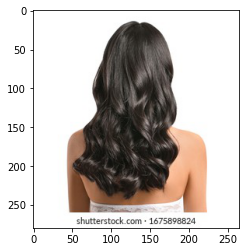

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
for fn in uploaded.keys():
  name = fn

img = mpimg.imread( name )
plt.imshow(img)

Predict

In [ ]:
path = '/content/young-asian-woman-beautiful-long-260nw-1675898824.jpg'
img = load_img(path, target_size= (256,256))
arr = tf.cast( img_to_array(img)/255.0 , tf.float32) 
arr = np.expand_dims(arr, 0)
arr.shape
output = model.predict( arr )

In [39]:
mask = np.squeeze(output, axis = (0,3) )
plt.imshow(mask, cmap='gray')

NameError: ignored

Download the model

In [ ]:
from google.colab import files

files.download( checkpoint_filepath+'/hair_segmentation.h5' )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>